In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

dataset_filename = 'top_1000_pe_imports.csv'
knn_model_filename = 'knnjoblib_file.sav'
rf_model_filename = 'rfjoblib_file.sav'
save_model = True

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Dataset
downloaded = drive.CreateFile({'id':"1uoSqL1UqTDnwvMEqdMTX5i-DY9cSwLdu"})
downloaded.GetContentFile(dataset_filename)

# if save_model == False:
#   # KNN Model
#   downloaded = drive.CreateFile({'id':"1Z3S-ArOzvsdQiunGBDvSK5JeMOo3dVjs"})
#   downloaded.GetContentFile(knn_model_filename)
#   # RF Model
#   downloaded = drive.CreateFile({'id':"1R-4_D02TqNlApBiI6CIzxTOuuv_hBMCD"})
#   downloaded.GetContentFile(rf_model_filename)

In [ ]:
def get_data():
  data = pd.read_csv(dataset_filename)
  data_sorted = data.sort_values('malware')
  data_sorted = data_sorted.head(5000)
  x = data_sorted.drop(["malware","hash"], axis = 1)
  y = data_sorted['malware']
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
  return (x, y)

def get_train_test_split(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
  return (x_train, x_test, y_train, y_test)

def plot_confusion_matrix(y_test, y_pred):
  cf_matrix1= confusion_matrix(y_test, y_pred)
  group_names = ["TrueNeg","FalsePos","FalseNeg","TruePos"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix1.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix1.flatten()/np.sum(cf_matrix1)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix1, annot=labels, fmt="", cmap='Blues')

def get_predictions_and_probabilities_KNN_and_RF(x):
  # knn_model = joblib.load(knn_model_filename)
  # rf_model = joblib.load(rf_model_filename)
  y_pred_knn_proba = np.array(knn.predict_proba(x))
  y_pred_rf_proba = np.array(clf2.predict_proba(x))
  y_pred_knn_proba = y_pred_knn_proba.T
  y_pred_rf_proba = y_pred_rf_proba.T
  data_dict = dict()
  data_dict["KNN Pred Prob 0"] = y_pred_knn_proba[0]
  data_dict["KNN Pred Prob 1"] = y_pred_knn_proba[1]
  data_dict["RF Pred Prob 0"] = y_pred_rf_proba[0]
  data_dict["RF Pred Prob 1"] = y_pred_rf_proba[1]
  df = pd.DataFrame(data_dict)
  print(df.head())
  return df

In [ ]:
x, y = get_data()
x_train, x_test, y_train, y_test = get_train_test_split(x, y)

KNN Model Saved to  knnjoblib_file.sav
KNN Accuracy:  89.59204285640293


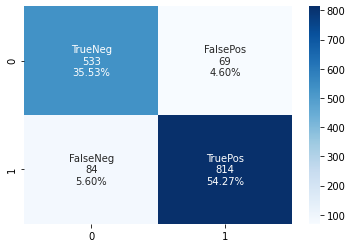

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12)
clf = knn.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc_knb_model=roc_auc_score(y_test, y_pred)*100

if save_model:
  joblib.dump(knn, knn_model_filename)
  print("KNN Model Saved to ", knn_model_filename)

print("KNN Accuracy: ", acc_knb_model)
plot_confusion_matrix(y_test, y_pred)

RF Model Saved to  rfjoblib_file.sav
RF Accuracy:  93.47664429629519


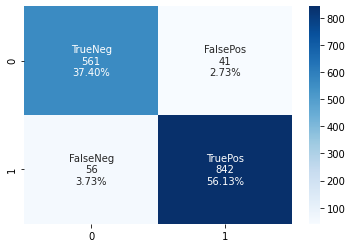

In [ ]:
clf2 = RandomForestClassifier(max_depth=45, random_state=4).fit(x_train, y_train)
y_pred2 = clf2.predict(x_test)
acc_rmf_model = roc_auc_score(y_test, y_pred2)*100

if save_model:
  joblib.dump(clf2, rf_model_filename)
  print("RF Model Saved to ", rf_model_filename)

print("RF Accuracy: ", acc_rmf_model)
plot_confusion_matrix(y_test, y_pred2)

# **Hybrid Classifier**

In [ ]:
pip install keras-adabound

In [ ]:
from keras_adabound import AdaBound

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.activations import sigmoid
from keras.optimizers import SGD
from keras.losses import binary_crossentropy
from keras.utils import to_categorical

In [ ]:
def get_hybrid_dataset():
  x, y = get_data()
  df = get_predictions_and_probabilities_KNN_and_RF(x)
  for col in df.columns:
    x[col] = list(df[col])
  return x, y

In [ ]:
x, y = get_hybrid_dataset()
x_train, x_test, y_train, y_test = get_train_test_split(x, y)

   KNN Pred Prob 0  KNN Pred Prob 1  RF Pred Prob 0  RF Pred Prob 1
0         0.916667         0.083333           0.940           0.060
1         1.000000         0.000000           1.000           0.000
2         1.000000         0.000000           1.000           0.000
3         1.000000         0.000000           0.994           0.006
4         0.333333         0.666667           0.850           0.150


In [ ]:
model = Sequential()
layers = [Dense(1004), Dense(512), Dense(251), Dense(63), Dense(16), Dense(4), Dense(1), Activation(sigmoid)]
for layer in layers:
  model.add(layer)

In [ ]:
model.compile(optimizer = SGD(learning_rate=0.0045, momentum=0.99, decay = 1e-4) , loss = binary_crossentropy, metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=512)

Epoch 1/200
7/7 [==============================] - 0s 6ms/step - loss: 0.7430 - accuracy: 0.6674
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.4686 - accuracy: 0.8759
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.2922 - accuracy: 0.9030
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.2003 - accuracy: 0.9366
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.2038 - accuracy: 0.9473
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 0.1847 - accuracy: 0.9603
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1983 - accuracy: 0.9555
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1729 - accuracy: 0.9524
Epoch 9/200
7/7 [==============================] - 0s 5ms/step - loss: 0.1254 - accuracy: 0.9580
Epoch 10/200
7/7 [==============================] - 0s 5ms/step - loss: 0.1235 - accuracy: 0.9591
Epoch 11/200
7/7 [===========

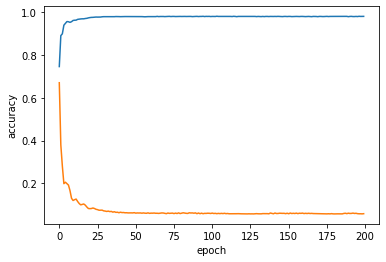

[[556  50]
 [ 46 848]]
93.39543762809936


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# "Loss"

y_pred = model.predict(x_test)
y_pred = (y_pred>0.5)
print(confusion_matrix(y_pred,y_test))
print(roc_auc_score(y_test, y_pred)*100)

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf3 = GaussianNB().fit(x_train, y_train)

In [ ]:
y_pred3 = clf3.predict(x_test)

In [ ]:
acc_nb=roc_auc_score(y_test, y_pred3)*100
acc_nb

73.34996929315051

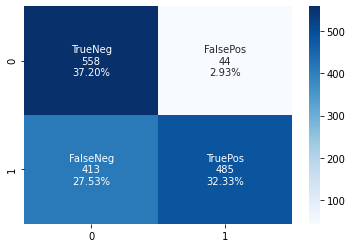

In [ ]:
cf_matrix3= confusion_matrix(y_test, y_pred3)
group_names = ["TrueNeg","FalsePos","FalseNeg","TruePos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix3.flatten()/np.sum(cf_matrix3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix3, annot=labels, fmt="", cmap='Blues')

In [ ]:
results = pd.DataFrame({
    'Model': ['KNN', 'Random Forest','Naive Bayes'],
    'Score': [acc_knb_model, acc_rmf_model, acc_nb]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
93.476644,Random Forest
89.592043,KNN
73.349969,Naive Bayes
